In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re

#helper function
import helper

#scikit-learn libraries
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

#h2o models and grid search
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#for XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import shap
import pandas as pd
import numpy as np
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('data/non_standardized_data.csv')

In [3]:
df.head()

,loan_id,customer_id,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,loan_given,11731.0,0,746.0,4.0,rent,50025.0,debt_consolidation,355.18,11.5,28.4,12,0,17391,37081.0,0.0,0.0
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,loan_refused,24613.0,1,744.8,6.0,rent,95414.0,business_loan,542.29,17.6,73.0,7,0,14123,16954.0,0.0,0.0
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,loan_given,19018.4,0,742.0,3.0,home_mortgage,64760.0,debt_consolidation,582.84,26.8,23.2,11,0,8880,22711.0,0.0,0.0
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,loan_given,11863.0,0,734.0,10.0,own_home,69202.0,debt_consolidation,859.26,30.3,33.2,7,0,9959,16995.0,0.0,0.0
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,loan_given,13719.0,0,724.0,1.0,own_home,34297.0,home_improvements,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0


In [4]:
df.drop(['loan_id', 'customer_id'], axis = 1, inplace = True)

In [5]:
df.purpose.value_counts()

purpose
debt_consolidation      70446
other                    7767
home_improvements        5205
business_loan            1328
buy_a_car                1196
medical_bills             955
buy_house                 559
take_a_trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
educational_expenses       92
vacation                   82
renewable_energy            9
Name: count, dtype: int64

1. Debt consolidation
2. Business loans
3. Personal loans
4. Other

In [6]:
purpose_mapping = {
    'debt_consolidation': 'debt_consolidation',
    'business_loan': 'business_loans',
    'small_business': 'business_loans',
    'other': 'other',
    'home_improvements': 'personal_loans',
    'buy_a_car': 'personal_loans',
    'medical_bills': 'personal_loans',
    'buy_house': 'personal_loans',
    'take_a_trip': 'personal_loans',
    'major_purchase': 'personal_loans',
    'moving': 'personal_loans',
    'wedding': 'personal_loans',
    'educational_expenses': 'personal_loans',
    'vacation': 'personal_loans',
    'renewable_energy': 'personal_loans',
}

df.replace({"purpose": purpose_mapping}, inplace=True)

df.purpose.value_counts()

purpose
debt_consolidation    70446
personal_loans         9119
other                  7767
business_loans         1576
Name: count, dtype: int64

In [7]:
df.head()

,loan_status,current_loan_amount,term,credit_score,years_in_current_job,home_ownership,annual_income,purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,maximum_open_credit,bankruptcies,tax_liens
0,loan_given,11731.0,0,746.0,4.0,rent,50025.0,debt_consolidation,355.18,11.5,28.4,12,0,17391,37081.0,0.0,0.0
1,loan_refused,24613.0,1,744.8,6.0,rent,95414.0,business_loans,542.29,17.6,73.0,7,0,14123,16954.0,0.0,0.0
2,loan_given,19018.4,0,742.0,3.0,home_mortgage,64760.0,debt_consolidation,582.84,26.8,23.2,11,0,8880,22711.0,0.0,0.0
3,loan_given,11863.0,0,734.0,10.0,own_home,69202.0,debt_consolidation,859.26,30.3,33.2,7,0,9959,16995.0,0.0,0.0
4,loan_given,13719.0,0,724.0,1.0,own_home,34297.0,personal_loans,777.38,13.6,2.0,12,0,6720,53335.0,0.0,0.0


In [8]:
df['debt_equity_ratio'] = df['monthly_debt'] / df['annual_income']
df['credit_utilization_ratio'] = df['current_credit_balance'] / df['maximum_open_credit']
df['is_months_delinquent_missing'] = df['months_since_last_delinquent'].isnull().astype(int)
df['has_stable_job'] = (df['years_in_current_job'] > 2).astype(int)

In [9]:
df_feature = df.copy()
df.drop(['bankruptcies', 'monthly_debt', 'annual_income', 'current_credit_balance', 'years_in_current_job', 'maximum_open_credit', 'months_since_last_delinquent', 'tax_liens'], axis = 1, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88908 entries, 0 to 88907
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   88908 non-null  object 
 1   current_loan_amount           88908 non-null  float64
 2   term                          88908 non-null  int64  
 3   credit_score                  88908 non-null  float64
 4   home_ownership                88908 non-null  object 
 5   purpose                       88908 non-null  object 
 6   years_of_credit_history       88908 non-null  float64
 7   number_of_open_accounts       88908 non-null  int64  
 8   number_of_credit_problems     88908 non-null  int64  
 9   debt_equity_ratio             88908 non-null  float64
 10  credit_utilization_ratio      88397 non-null  float64
 11  is_months_delinquent_missing  88908 non-null  int32  
 12  has_stable_job                88908 non-null  int32  
dtypes

In [11]:
df.isnull().sum()

loan_status                       0
current_loan_amount               0
term                              0
credit_score                      0
home_ownership                    0
purpose                           0
years_of_credit_history           0
number_of_open_accounts           0
number_of_credit_problems         0
debt_equity_ratio                 0
credit_utilization_ratio        511
is_months_delinquent_missing      0
has_stable_job                    0
dtype: int64

In [12]:
#impute using KNNImputer
imputer = KNNImputer(n_neighbors=5)
column_names_to_impute = ['credit_utilization_ratio']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=column_names_to_impute)
imputed = imputer.fit_transform(df[column_names_to_impute].values)

joblib.dump(imputer, 'model/knn_imputer_model_engineered.pkl')

data_temp = pd.DataFrame(imputed, columns=column_names_to_impute, index = df.index)
df[column_names_to_impute] = data_temp

#sanity checking
df.isnull().sum()

loan_status                     0
current_loan_amount             0
term                            0
credit_score                    0
home_ownership                  0
purpose                         0
years_of_credit_history         0
number_of_open_accounts         0
number_of_credit_problems       0
debt_equity_ratio               0
credit_utilization_ratio        0
is_months_delinquent_missing    0
has_stable_job                  0
dtype: int64

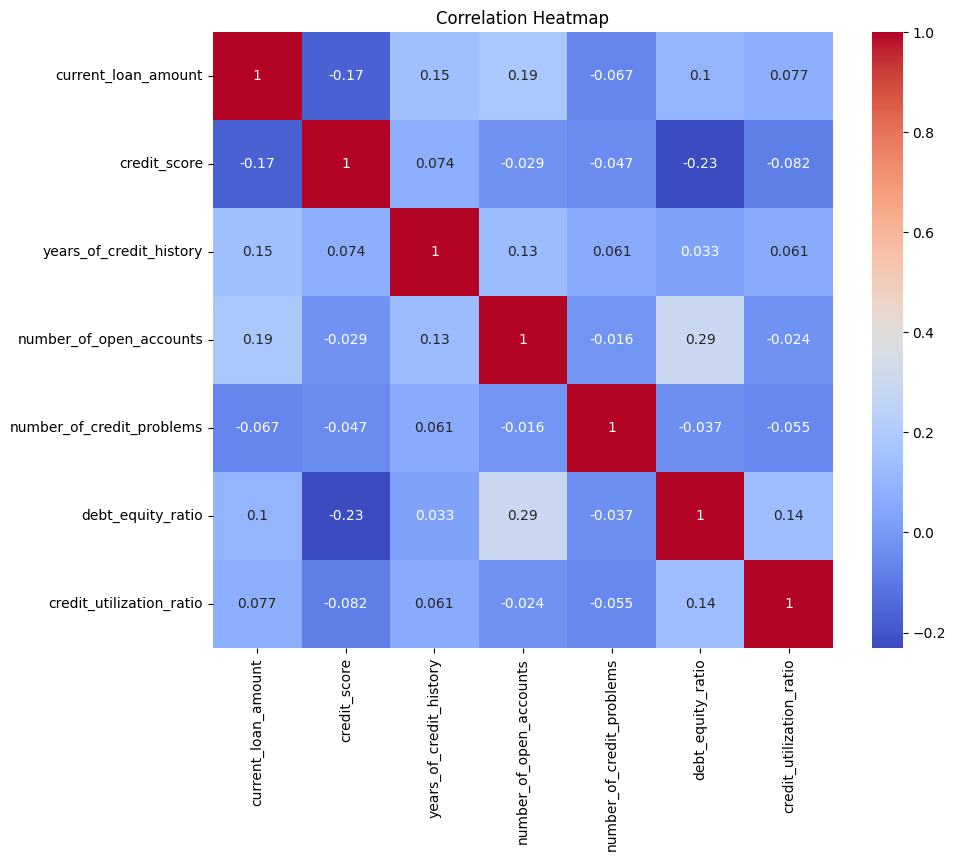

In [13]:
corr_matrix = df[['current_loan_amount', 'credit_score', 'years_of_credit_history', 'number_of_open_accounts', 'number_of_credit_problems', 'debt_equity_ratio', 'credit_utilization_ratio']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show();

In [14]:
#create dummies variable (one hot encode)
dummies = pd.get_dummies(df['purpose'], prefix='purpose', drop_first = True)
df[dummies.columns] = dummies

dummies = pd.get_dummies(df['home_ownership'], prefix='home', drop_first = True)
df[dummies.columns] = dummies

df = df.drop(["home_ownership", "purpose"], axis=1)
df = df.replace({True: 1, False: 0})

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88298 entries, 0 to 88907
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   88298 non-null  object 
 1   current_loan_amount           88298 non-null  float64
 2   term                          88298 non-null  int64  
 3   credit_score                  88298 non-null  float64
 4   years_of_credit_history       88298 non-null  float64
 5   number_of_open_accounts       88298 non-null  int64  
 6   number_of_credit_problems     88298 non-null  int64  
 7   debt_equity_ratio             88298 non-null  float64
 8   credit_utilization_ratio      88298 non-null  float64
 9   is_months_delinquent_missing  88298 non-null  int32  
 10  has_stable_job                88298 non-null  int32  
 11  purpose_debt_consolidation    88298 non-null  int64  
 12  purpose_other                 88298 non-null  int64  
 13  purpos

In [16]:
cols_to_standardize = ['current_loan_amount', 'credit_score', 'years_of_credit_history', 'number_of_open_accounts', 'number_of_credit_problems']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[cols_to_standardize].values)

data_temp = pd.DataFrame(data_scaled, columns=cols_to_standardize, index = df.index)
df[cols_to_standardize] = data_temp

In [17]:
#save the scaler
scaler_filename = 'model/scaler_engineered.pkl'
joblib.dump(scaler, scaler_filename)

['model/scaler_engineered.pkl']

In [18]:
df.to_csv('data/final_data_engineered.csv', index = False)

# Model Training

## H2O Gradient Boosting Model

In [19]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\agust\Anaconda3\envs\h2o_loan_classification\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\agust\AppData\Local\Temp\tmptfda7ei0
  JVM stdout: C:\Users\agust\AppData\Local\Temp\tmptfda7ei0\h2o_agust_started_from_python.out
  JVM stderr: C:\Users\agust\AppData\Local\Temp\tmptfda7ei0\h2o_agust_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Jakarta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_agust_jrhk5n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.854 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [20]:
#parsing the dataframe to H2O dataframe
hf = h2o.H2OFrame(df)

#separating predictors and response
predictors = list(df.columns[1:])
response = "loan_status"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
#create train, test, and validation dataset
train_temp, test = hf.split_frame(ratios = [.8], seed = 42)
train, val = train_temp.split_frame(ratios = [.8], seed = 42)

In [ ]:
learn_rate = [0.01, 0.05, 0.1]
max_depth = [5, 7, 9]
ntrees = [300, 500, 700]
sample_rate = [0.5, 0.8, 1.0]
col_sample_rate = [0.25, 0.5, 1.0]
best_gbm1, gbm_perf, gbm_gridperf1 = helper.train_gbm_h2o(predictors, response, train, test, val, learn_rate, max_depth, ntrees, sample_rate, col_sample_rate)

#hyperparameters to tune
gbm_params1 = {'learn_rate': [0.01, 0.05, 0.1],
                'max_depth': [5, 7, 9],
                'ntrees': [300, 500, 700],
                'sample_rate': [0.5, 0.8, 1.0],
                'col_sample_rate': [0.25, 0.5, 1.0]}

#initializing grid search
gbm_grid1 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id='gbm_grid1',
    hyper_params=gbm_params1
)

#model training
gbm_grid1.train(
    x=predictors,
    y=response,
    training_frame=train,
    validation_frame=val,  # Include your validation frame here
    seed=42
)

In [24]:
gbm_gridperf1

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,1.0,0.01,7.0,700.0,0.8,gbm_grid1_model_147,0.4609114
,1.0,0.01,7.0,700.0,0.5,gbm_grid1_model_66,0.4605907
,1.0,0.05,5.0,500.0,0.8,gbm_grid1_model_114,0.4605097
,1.0,0.05,5.0,700.0,0.8,gbm_grid1_model_141,0.4605097
,1.0,0.05,5.0,300.0,0.8,gbm_grid1_model_87,0.4605097
,1.0,0.01,7.0,500.0,0.8,gbm_grid1_model_120,0.4601493
,0.5,0.05,5.0,500.0,0.8,gbm_grid1_model_113,0.4601478
,0.5,0.05,5.0,700.0,0.8,gbm_grid1_model_140,0.4601478
,0.5,0.05,5.0,300.0,1.0,gbm_grid1_model_167,0.4601291
,0.5,0.05,5.0,500.0,1.0,gbm_grid1_model_194,0.4601291


#get the best model
best_gbm1 = gbm_gridperf1.models[0]

#evaluate the model against the test data
perf = best_gbm1.model_performance(test)
print(perf)

In [ ]:
print(gbm_perf)

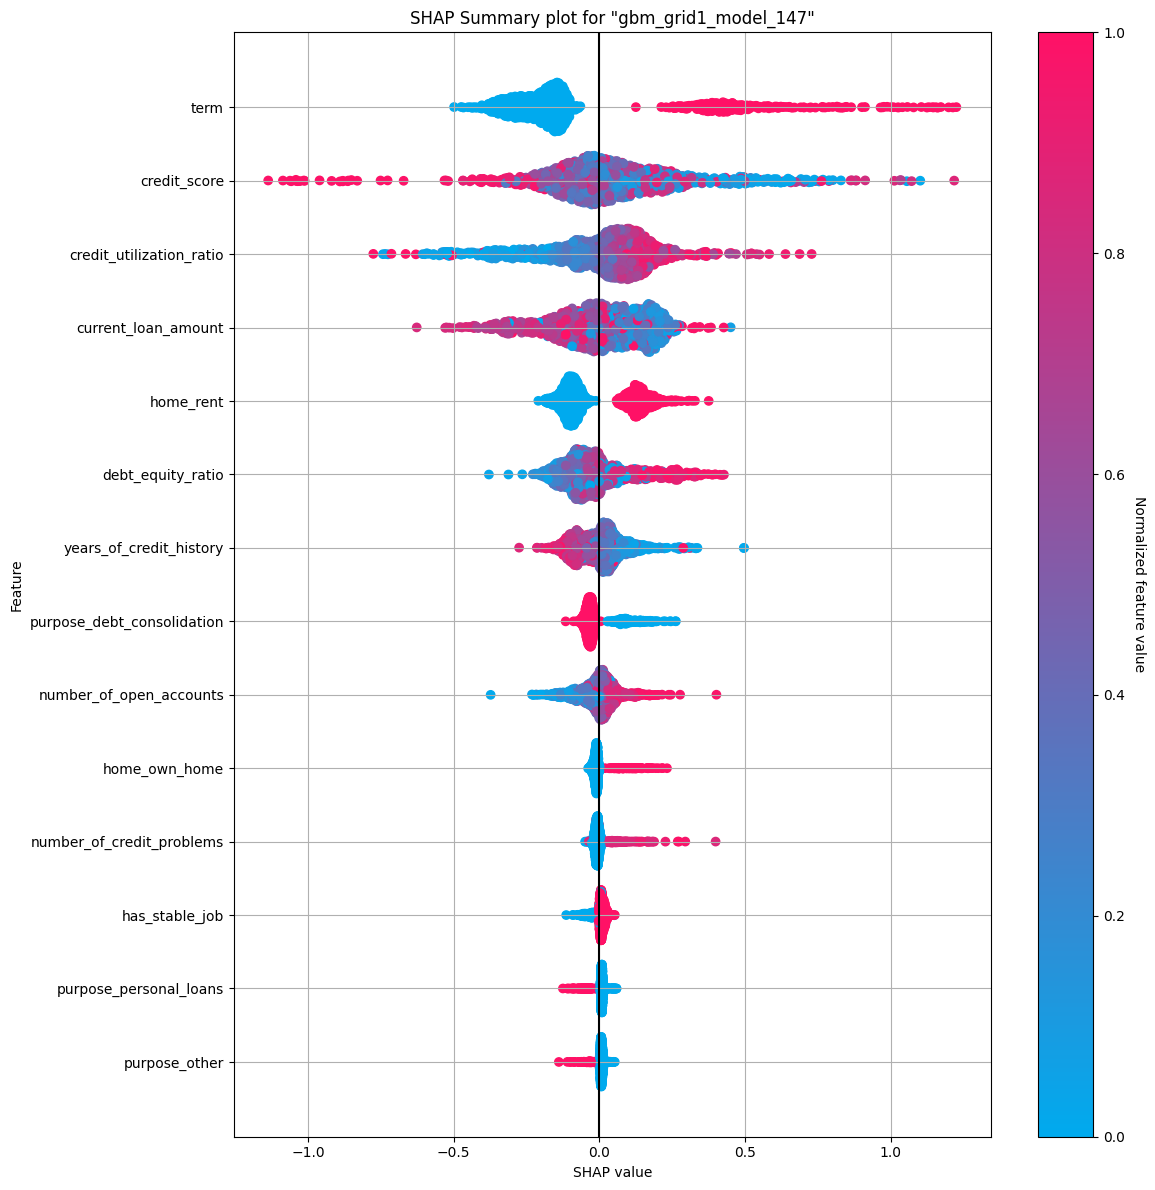

In [26]:
best_gbm1.shap_summary_plot(test)

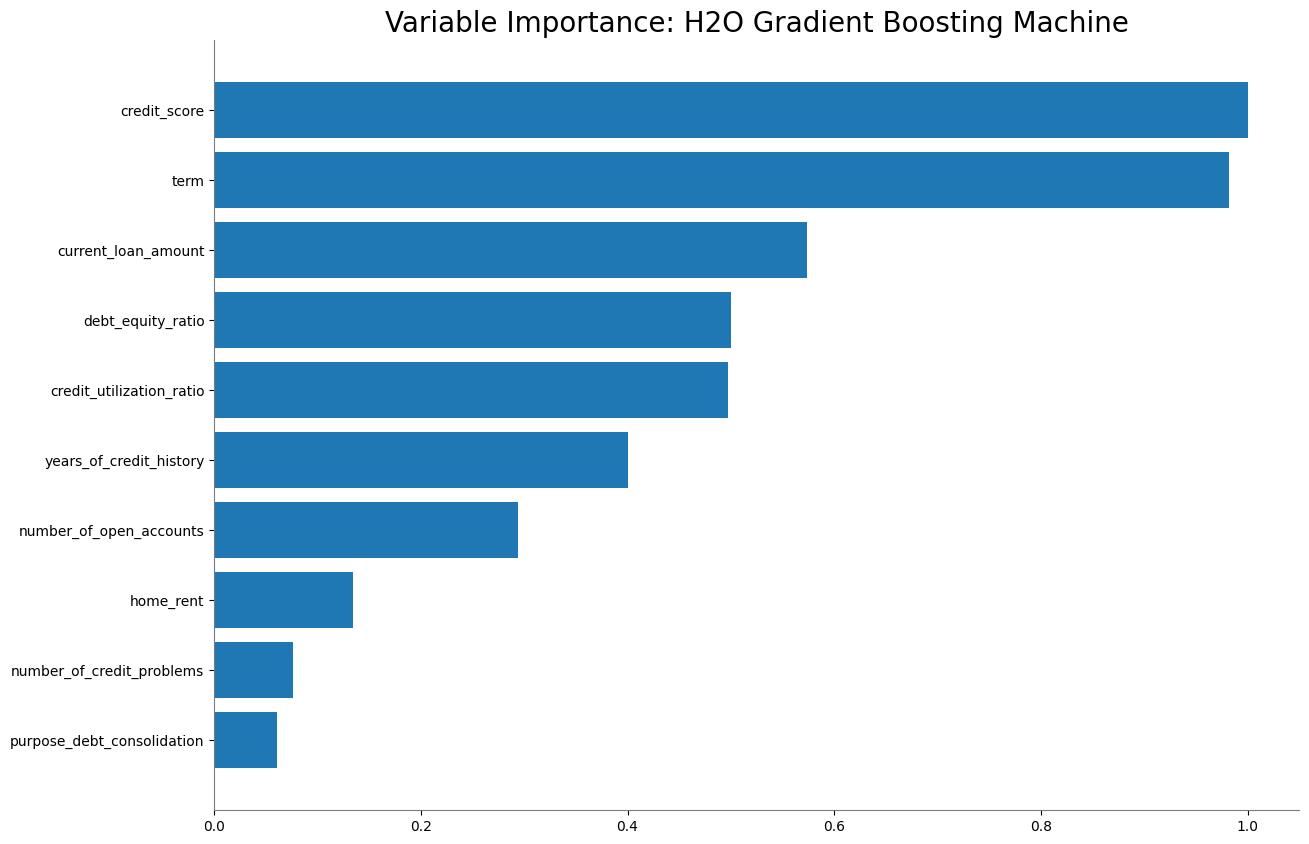

<Figure size 640x480 with 0 Axes>

In [27]:
best_gbm1.varimp_plot()

In [50]:
f1_gbm, precision_gbm, recall_gbm, auc_gbm = helper.calculate_metrics_summary(gbm_perf, df, 'GBM')

In [28]:
#saving model
model_path = h2o.save_model(
  best_gbm1,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\gbm_grid1_model_147'

## Using Deep Learning

In [ ]:
hidden = [[16, 16], [16, 32, 64], [16, 32, 64, 128]]
epochs = [50, 100, 200]
balance_classes = [True, False]
activation = ['Rectifier', 'Tanh', 'RectifierWithDropout','Maxout']
best_dl_model, dl_perf = train_dl_h2o(predictors, response, train, test, val, hidden, epochs, balance_classes, activation)

In [ ]:
print(dl_perf)

## Using XGBoost

In [ ]:
best_xgb_model, X_test, y_test = train_xgboost(df, n_estimators, max_depth, subsample, reg_alpha, reg_lambda, learning_rate, max_bin)

In [ ]:
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test)

#shap summary plot
shap.summary_plot(shap_values, X_test)

In [ ]:
#bar chart for shap values
shap.plots.bar(shap_values)

In [ ]:
f1_xgb, precision_xgb, recall_xgb, auc_xgb = helper.calculate_model_metrics_xgboost(best_xgb_model, X_test, y_test, y_pred, "XGBoost")

#separate predictors and target
X = df.drop('loan_status', axis=1)
y = pd.DataFrame(df['loan_status'])

#mapping the target variable to 0 and 1 so that the algorithm works
mapping = {
    'loan_refused': 0,
    'loan_given': 1
}
y['loan_status'] = y['loan_status'].map(mapping)

#split the dataset into train, test, and validation
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

print(f'The number of training dataset is {X_train.shape[0]}, the number of validation dataset is {X_val.shape[0]}, and the number of testing dataset is {X_test.shape[0]}.')

#hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 0.8],
    'reg_lambda': [0, 0.1, 0.5, 0.8],
    'learning_rate': [0.1, 0.01, 0.01],
    'max_bin': [128, 256, 512]
}

#Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42, eval_metric='auc', early_stopping_rounds=10)

#Initialize GridSearchCV with the XGBoost classifier and parameter grid
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

#Fit the grid search to the training data
grid_search.fit(X_train, y_train,eval_set=[(X_val, y_val)], verbose = 0)

#Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

#Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_auc = best_model.score(X_test, y_test)
print("Test AUC Score:", test_auc)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_val)

#shap summary plot
shap.summary_plot(shap_values, X_val)

#bar chart for shap values
shap.plots.bar(shap_values)

from sklearn.metrics import confusion_matrix
import seaborn as sns

#evaluate the model on the test dataset
y_pred = best_model.predict(X_test)

#Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

class_names = ['loan_refused', 'loan_given']

#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Actual vs Predicted)')
plt.show();

#saving the model
import joblib

joblib.dump(best_model, 'model/best_xgb_model_engineered.pkl')

In [ ]:
models = ['GBM', 'XGBoost']
f1_scores = [f1_gbm, f1_xgb]
precision_scores = [precision_gbm, precision_xgb]
recall_scores = [recall_gbm, recall_xgb]
auc_scores = [auc_gbm, auc_xgb]
scores_df = helper.compare_score(f1_scores, precision_scores, recall_scores, auc_scores, models)